# Neural Networks

This notebook will attempt to train some Neural Networks on the Training data and save it for later use

## Author: Alexander Goudemond, Student Number: 219030365

In this notebook, we are going to begin looking at training some neural networks.

I have tried to go through several U-net tutorials - all of which failed. I suspect there is a combination of problems affecting me:

- The tutorial data-sets are not clean or not accessible (hosted on private servers or websites, like Kaggle, Medium, PyImageSearch)

- The implementation is complicated and built on old dependencies

- there is too much data being brought in for training at one time, for offline use

- the offline training I have been trying to do is not possible, as my Graphics Card does not have enough VRAM

To try and overcome these challenges - I am going to load a single folder from our data-set into some training variables, and attempt to train a model on just those. I am unable to do an example tutorial - so I am hoping for the best with my implementation

# Mount Drive

We need to access some images loaded into Google Drive, so here we mount it

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Please ensure the following folders exist

drive > MyDrive > COMP700_Images > COMP700_Training_GT

drive > MyDrive > COMP700_Images > COMP700_Training_ST

drive > MyDrive > COMP700_Neural_Network_Code

The latter location is where the Jupyter Notebooks will be loaded, and the former directories will contain the images used. These images are generated offline by the other notebooks and then uploaded to Google Drive

# Imports

In [2]:
from os import getcwd, walk, mkdir, stat, remove
from os import sep # used later on, in a function, to print directory contents
from os.path import exists, basename, join

from shutil import copyfile

from PIL.Image import fromarray
import cv2

import matplotlib.pyplot as plt
import numpy as np

# Load images into variables

We will be going to our training data and fetching 1 folder for our x and y training variables. Once that is successful, we will explore training on each of the datasets together

In [3]:
getcwd()

'/content'

In [4]:
google_drive_path = "/drive/MyDrive"
training_data_folder = "COMP700_Training_GT"
training_data_directory = getcwd() + google_drive_path + "/COMP700_Images/" + training_data_folder
desired_directory = ""
training_data_all_directories = []

# cycle up until we hit an "X"
for root, dirs, files in walk(training_data_directory):
    desired_directory = root
    if (dirs[0] == "X") or (dirs[0] == "Y"):
        break

print(desired_directory)


/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/PhC-C2DH-U373/PhC-C2DH-U373/01


We know that this variable desired_directory contains 2 folders: X and Y, so we can generate our X and Y paths now

In [5]:
x_training_paths = []
y_training_paths = []

for root, dirs, files in walk(desired_directory):
    if ("X" in root):
        x_training_paths = files
    else:
        y_training_paths = files

print("Length of X Training:", len(x_training_paths))
print("Length of Y Training:", len(y_training_paths))

# update the paths:

for i in range(len(x_training_paths)):
    x_training_paths[i] = desired_directory + "/X/" + x_training_paths[i]
    y_training_paths[i] = desired_directory + "/Y/" + y_training_paths[i]

Length of X Training: 15
Length of Y Training: 15


We can now try to write those images into an array of images:

In [6]:
x_training_images = []
y_training_images = []

for i in range(len(x_training_paths)):
    x_training_images.append( cv2.imread(x_training_paths[i]) )
    y_training_images.append( cv2.imread(y_training_paths[i]) )

Let's now try show these images side by side to verify results:

Shape: (520, 696, 3)


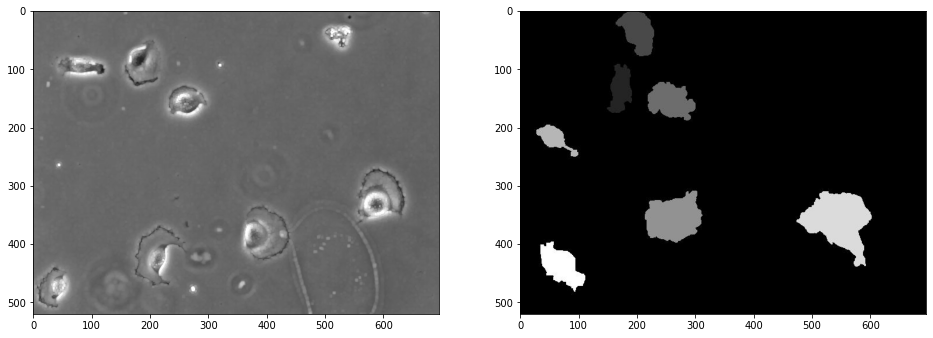

In [7]:
from random import randint

index = randint(0, len(x_training_images) - 1)
print("Shape:", y_training_images[index].shape)

fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.imshow(x_training_images[index])

plt.subplot(1, 2, 2)
plt.imshow(y_training_images[index])

plt.show()

Okay! We have taken a very small sample of images and loaded them correctly. We can now try train a simple U Net model and see if it will run. Hopefully it will...

# Prepare Dataset for Model

The model may be complaining because the initial dimensions of the images are incorrect. Let us try adjust them to be (128, 128, 3)

OpenCV has a parameter interpolation, which may assist with resizing the images. Let us compare the results before resizing:

[optional] flag that takes one of the following methods. INTER_NEAREST – a nearest-neighbor interpolation INTER_LINEAR – a bilinear interpolation (used by default) INTER_AREA – resampling using pixel area relation. It may be a preferred method for image decimation, as it gives moire’-free results. But when the image is zoomed, it is similar to the INTER_NEAREST method. INTER_CUBIC – a bicubic interpolation over 4×4 pixel neighborhood INTER_LANCZOS4 – a Lanczos interpolation over 8×8 pixel neighborhood

In [8]:
def resizeNoInterpolation(img):
    return cv2.resize(img, dim)
###
def resizeNearestInterpolation(img):
    return cv2.resize(img, dim, cv2.INTER_NEAREST)
###
def resizeLinearInterpolation(img):
    return cv2.resize(img, dim, cv2.INTER_LINEAR)
###
def resizeAreaInterpolation(img):
    return cv2.resize(img, dim, cv2.INTER_AREA)
###
def resizeCubicInterpolation(img):
    return cv2.resize(img, dim, cv2.INTER_CUBIC)
###
def resizeLanczos4Interpolation(img):
    return cv2.resize(img, dim, cv2.INTER_LANCZOS4)
###

def switchResizes(img, number):
    new_img = img
    
    if (number == 0):
        new_img = resizeNoInterpolation(img)
    elif(number == 1):
        new_img = resizeNearestInterpolation(img)
    elif(number == 2):
        new_img = resizeLinearInterpolation(img)
    elif(number == 3):
        new_img = resizeAreaInterpolation(img)
    elif(number == 4):
        new_img = resizeCubicInterpolation(img)
    elif(number == 5):
        new_img = resizeLanczos4Interpolation(img)
    else:
        print("Number out of range")
    
    return new_img
###

Shape: (520, 696, 3)


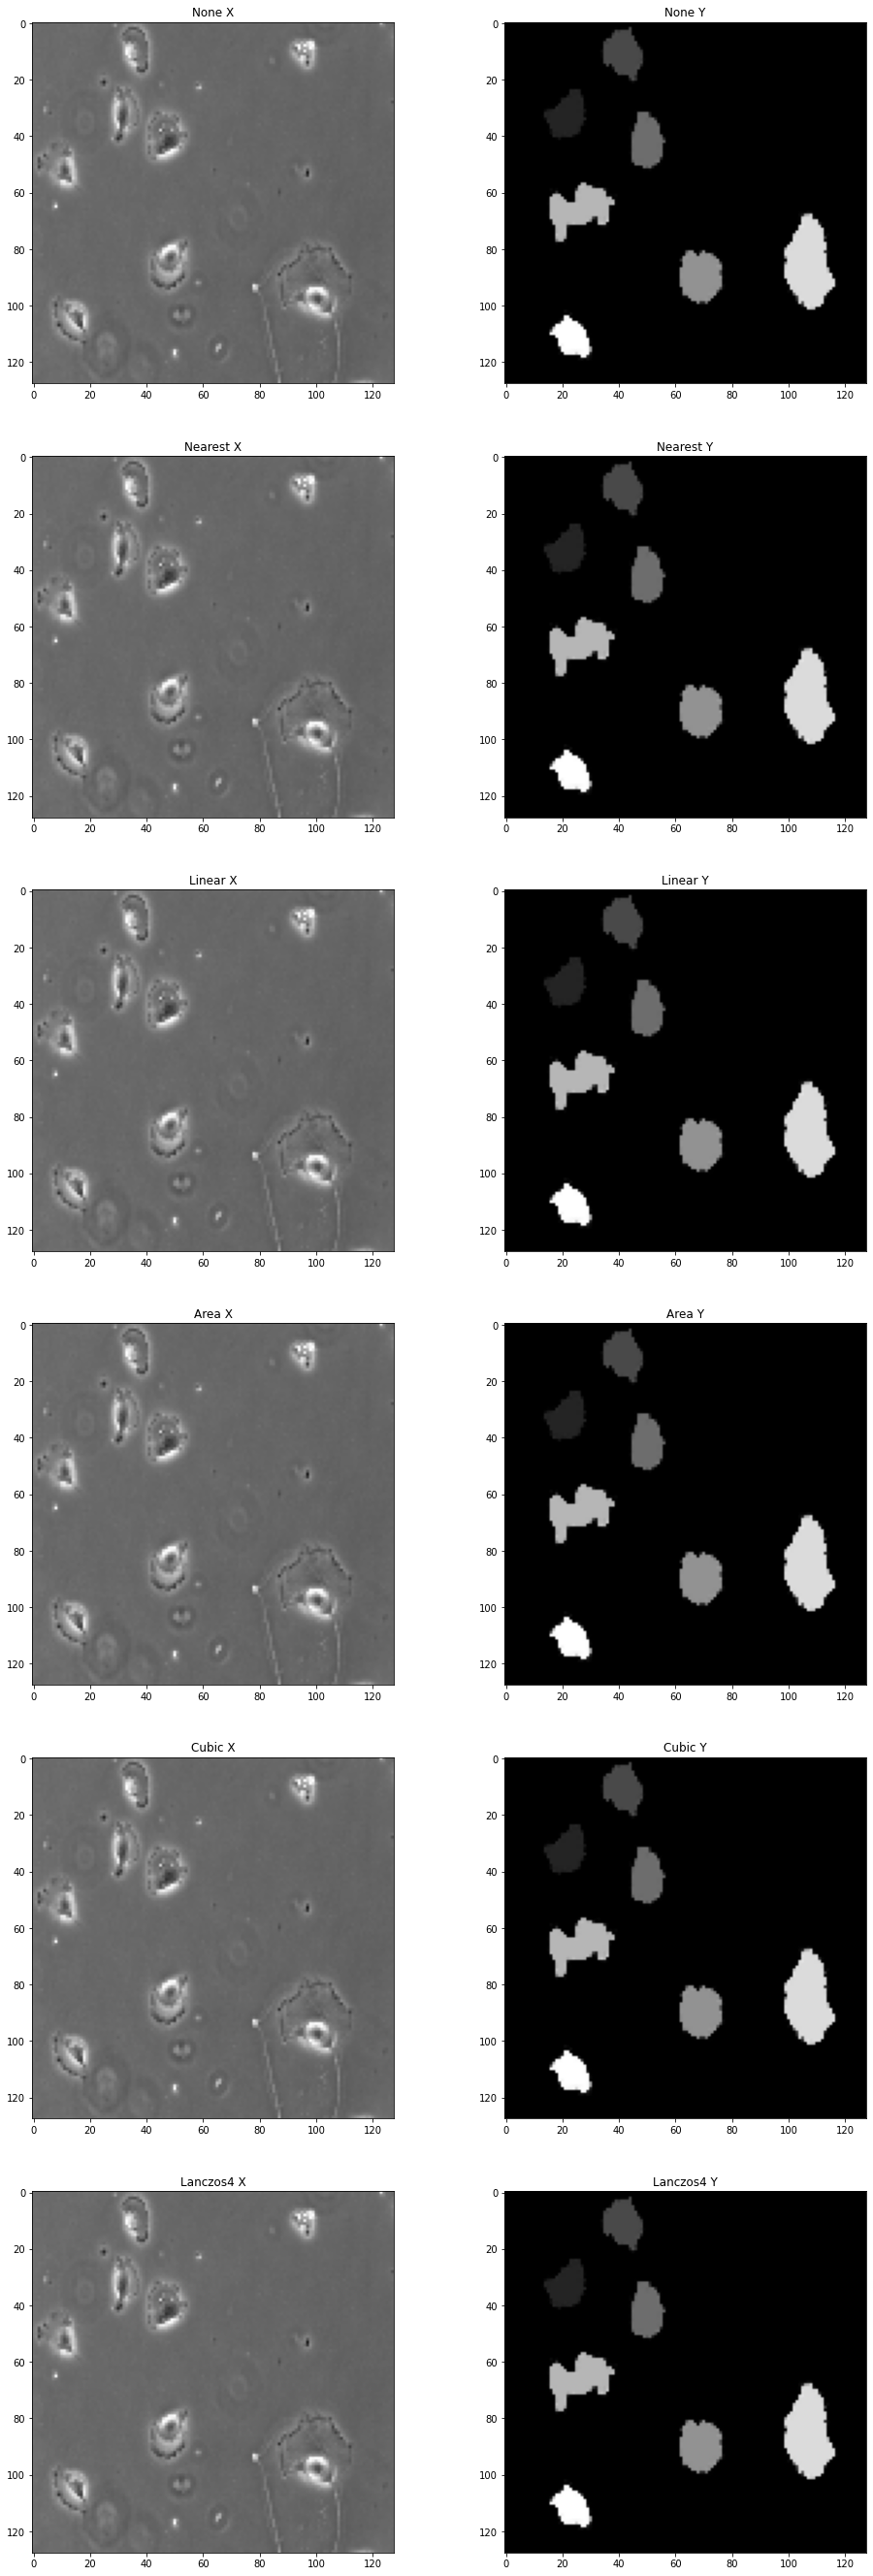

In [9]:
index = randint(0, len(x_training_images) - 1)
print("Shape:", y_training_images[index].shape)

x_img = x_training_images[index]
y_img = y_training_images[index]

resize_args = ["None", "Nearest", "Linear", "Area", "Cubic", "Lanczos4"]

fig = plt.figure(figsize=(16,48))
numrows = 6
numcols = 2

dim = (128, 128)

for i in range(len(resize_args)):
    plt.subplot(numrows, numcols, i*2+1)
    plt.title(resize_args[i] + " X")
    plt.imshow( switchResizes(x_img, i) )

    plt.subplot(numrows, numcols, i*2+2)
    plt.title(resize_args[i] + " Y")
    plt.imshow( switchResizes(y_img, i) )

plt.show()

It does not appear to make any difference!

In [10]:
x_training_images_resized = []
y_training_images_resized = []
dim = (128, 128)

for i in range(len(y_training_images)):
    img = x_training_images[i]
    x_training_images_resized.append( cv2.resize(img, dim) ) 

    img = y_training_images[i]
    y_training_images_resized.append( cv2.resize(img, dim) ) 

In [11]:
image_shape = (x_training_images_resized[0]).shape
print(image_shape)
print(image_shape[0])

(128, 128, 3)
128


In [12]:
TRAIN_LENGTH = len(x_training_images_resized)

partition_index = (int) (0.8 * TRAIN_LENGTH)

x_train = x_training_images_resized[ : partition_index ]
y_train = y_training_images_resized[ : partition_index ]

x_valid = x_training_images_resized[ : partition_index ]
y_valid = y_training_images_resized[ : partition_index ]

# convert to numpy arrays for tensorflow
x_train = np.array(x_train)
y_train = np.array(y_train)

x_valid = np.array(x_valid)
y_valid = np.array(y_valid)

data_valid = (x_valid, y_valid)

# U-Net Tensorflow Tut



The code below attempts to load a pre-trained model - I am unable to get it working

In [13]:
# !pip install git+https://github.com/tensorflow/examples.git

In [14]:
# import tensorflow as tf

# from tensorflow_examples.models.pix2pix import pix2pix

# from IPython.display import clear_output

The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). To learn robust features and reduce the number of trainable parameters, use a pretrained model—MobileNetV2—as the encoder. For the decoder, you will use the upsample block, which is already implemented in the pix2pix example in the TensorFlow Examples repo. (Check out the pix2pix: Image-to-image translation with a conditional GAN tutorial in a notebook.)

As mentioned, the encoder is a pretrained MobileNetV2 model. You will use the model from tf.keras.applications. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [15]:
# base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

In [16]:
# # Use the activations of these layers
# layer_names = [
#     'block_1_expand_relu',   # 64x64
#     'block_3_expand_relu',   # 32x32
#     'block_6_expand_relu',   # 16x16
#     'block_13_expand_relu',  # 8x8
#     'block_16_project',      # 4x4
# ]
# base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# base_model_outputs

In [17]:
# # Create the feature extraction model
# down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# down_stack.trainable = False

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples:

In [18]:
# up_stack = [
#     pix2pix.upsample(512, 3),  # 4x4 -> 8x8
#     pix2pix.upsample(256, 3),  # 8x8 -> 16x16
#     pix2pix.upsample(128, 3),  # 16x16 -> 32x32
#     pix2pix.upsample(64, 3),   # 32x32 -> 64x64
# ]

# up_stack

In [19]:
# def unet_model(output_channels:int):
#   inputs = tf.keras.layers.Input(shape=[128, 128, 3])

#   # Downsampling through the model
#   skips = down_stack(inputs)
#   x = skips[-1]
#   skips = reversed(skips[:-1])

#   # Upsampling and establishing the skip connections
#   for up, skip in zip(up_stack, skips):
#     x = up(x)
#     concat = tf.keras.layers.Concatenate()
#     x = concat([x, skip])

#   # This is the last layer of the model
#   last = tf.keras.layers.Conv2DTranspose(
#       filters=output_channels, kernel_size=3, strides=2,
#       padding='same')  #64x64 -> 128x128

#   x = last(x)

#   return tf.keras.Model(inputs=inputs, outputs=x)


Note that the number of filters on the last layer is set to the number of output_channels. This will be one output channel per class.

## Train the model

Now, all that is left to do is to compile and train the model.

Since this is a multiclass classification problem, use the tf.keras.losses.CategoricalCrossentropy loss function with the from_logits argument set to True, since the labels are scalar integers instead of vectors of scores for each pixel of every class.

When running inference, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

In [20]:
# OUTPUT_CLASSES = 3

# model = unet_model(output_channels=OUTPUT_CLASSES)
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])


In [21]:
# tf.keras.utils.plot_model(model, show_shapes=True)


In [22]:
# model.summary()

Try out the model to check what it predicts before training:

In [23]:
# def create_mask(pred_mask):
#   pred_mask = tf.math.argmax(pred_mask, axis=-1)
#   pred_mask = pred_mask[..., tf.newaxis]
#   return pred_mask[0]


In [24]:
# sample_image = cv2.resize(x_img, dim)
# sample_mask = cv2.resize(y_img, dim)

# sample_image.shape

In [25]:
# def display(display_list):
#   plt.figure(figsize=(15, 15))

#   title = ['Input Image', 'True Mask', 'Predicted Mask']

#   for i in range(len(display_list)):
#     plt.subplot(1, len(display_list), i+1)
#     plt.title(title[i])
#     plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
#     plt.axis('off')
#   plt.show()

# def show_predictions(dataset=None, num=1):
#   if dataset:
#     for image, mask in dataset.take(num):
#       pred_mask = model.predict(image)
#       display([image[0], mask[0], create_mask(pred_mask)])
#   else:
#     display([sample_image, sample_mask,
#              create_mask(model.predict(sample_image[tf.newaxis, ...]))])


In [26]:
# show_predictions()

The callback defined below is used to observe how the model improves while it is training:

In [27]:
# class DisplayCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     clear_output(wait=True)
#     show_predictions()
#     print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


In [28]:
# EPOCHS = 20
# VAL_SUBSPLITS = 5
# TRAIN_LENGTH = len(x_training_images_resized)
# BATCH_SIZE = 8
# BUFFER_SIZE = 1000
# STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# # VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
# VALIDATION_STEPS = TRAIN_LENGTH // BATCH_SIZE // VAL_SUBSPLITS

# partition_index = (int) (0.8 * TRAIN_LENGTH)

# x_train = x_training_images_resized[ : partition_index ]
# y_train = y_training_images_resized[ : partition_index ]

# x_valid = x_training_images_resized[ : partition_index ]
# y_valid = y_training_images_resized[ : partition_index ]

# # convert to numpy arrays
# x_train = np.array(x_train)
# y_train = np.array(y_train)

# x_valid = np.array(x_valid)
# y_valid = np.array(y_valid)

# data_valid = (x_valid, y_valid)


I am unable to get this working, so let us try the following:



In [29]:
# sample_image = np.array(sample_image)
# sample_mask = np.array(sample_mask)

Skip because cant get working for now

In [30]:
# # try reshaping:

# x_train_reshaped = x_train.reshape((-1,1)).shape

# x_train_reshaped

In [31]:
# model_history = model.fit(x=x_train, y=y_train, epochs=EPOCHS,
#                           steps_per_epoch=STEPS_PER_EPOCH,
#                           validation_steps=VALIDATION_STEPS,
#                           #validation_data=y_train,
#                           callbacks=[DisplayCallback()]
#                           )

# Designing the U-Net Model

URL: https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5

Uncomment to get working!

In [32]:
# import tensorflow as tf
# from tensorflow.python.keras.models import Model
# from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout, Lambda
# from tensorflow.python.keras import backend as K

In [33]:
# def build_model(input_layer, start_neurons):
    
#     conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
#     conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
#     pool1 = MaxPooling2D((2, 2))(conv1)
#     pool1 = Dropout(0.25)(pool1)

    
#     conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
#     conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
#     pool2 = MaxPooling2D((2, 2))(conv2)
#     pool2 = Dropout(0.5)(pool2)

    
#     conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
#     conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
#     pool3 = MaxPooling2D((2, 2))(conv3)
#     pool3 = Dropout(0.5)(pool3)

    
#     conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
#     conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
#     pool4 = MaxPooling2D((2, 2))(conv4)
#     pool4 = Dropout(0.5)(pool4)

    
#     # Middle
#     convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
#     convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    
#     deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
#     uconv4 = concatenate([deconv4, conv4])
#     uconv4 = Dropout(0.5)(uconv4)
#     uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
#     uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    
#     deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
#     uconv3 = concatenate([deconv3, conv3])
#     uconv3 = Dropout(0.5)(uconv3)
#     uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
#     uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    
#     deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
#     uconv2 = concatenate([deconv2, conv2])
#     uconv2 = Dropout(0.5)(uconv2)
#     uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
#     uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    
#     deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
#     uconv1 = concatenate([deconv1, conv1])
#     uconv1 = Dropout(0.5)(uconv1)
#     uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
#     uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    

#     output_layer = Conv2D(3, (1,1), padding="same", activation="sigmoid", name="fox")(uconv1) # modified initial parameter

#     print("Model ready!")
    
#     return output_layer
# ###


In [34]:
# input_layer = Input(shape=(128, 128, 3))
# output_layer = build_model(input_layer, 16)

In [35]:
# # Define the model
# unet_model = Model(inputs=[input_layer], outputs=[output_layer])

# unet_model.summary()

Lets try plot the model visually:

In [36]:
# tf.keras.utils.plot_model(unet_model, show_shapes=True)

Compile:

In [37]:
# # unet_model.compile(optimizer='adam',
# #               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
# #               metrics=['accuracy'])

# unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Train:

In [38]:
# EPOCHS = 20
# BATCH_SIZE = 32

In [39]:
# unet_model_history = unet_model.fit(
#                                     x=x_train, 
#                                     y=y_train,
#                                     batch_size=BATCH_SIZE,
#                                     epochs=EPOCHS,
#                                     validation_data=data_valid # also works with this in!
#                                     )

# Attempt 3 U-Net

URL: https://github.com/bnsreenu/python_for_microscopists

## Installs

In [40]:
import tensorflow as tf
from tensorflow import keras

from keras.layers import Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Input, Lambda

In [41]:
# original author: "Sreenivas Bhattiprolu"
# Github directory: "Python for Microscopists"
# URL: https://github.com/bnsreenu/python_for_microscopists
def unet_v3(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS):
    #Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9) # modified initial parameter to 3
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model
###

In [42]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

unet_model = unet_v3(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

In [43]:
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

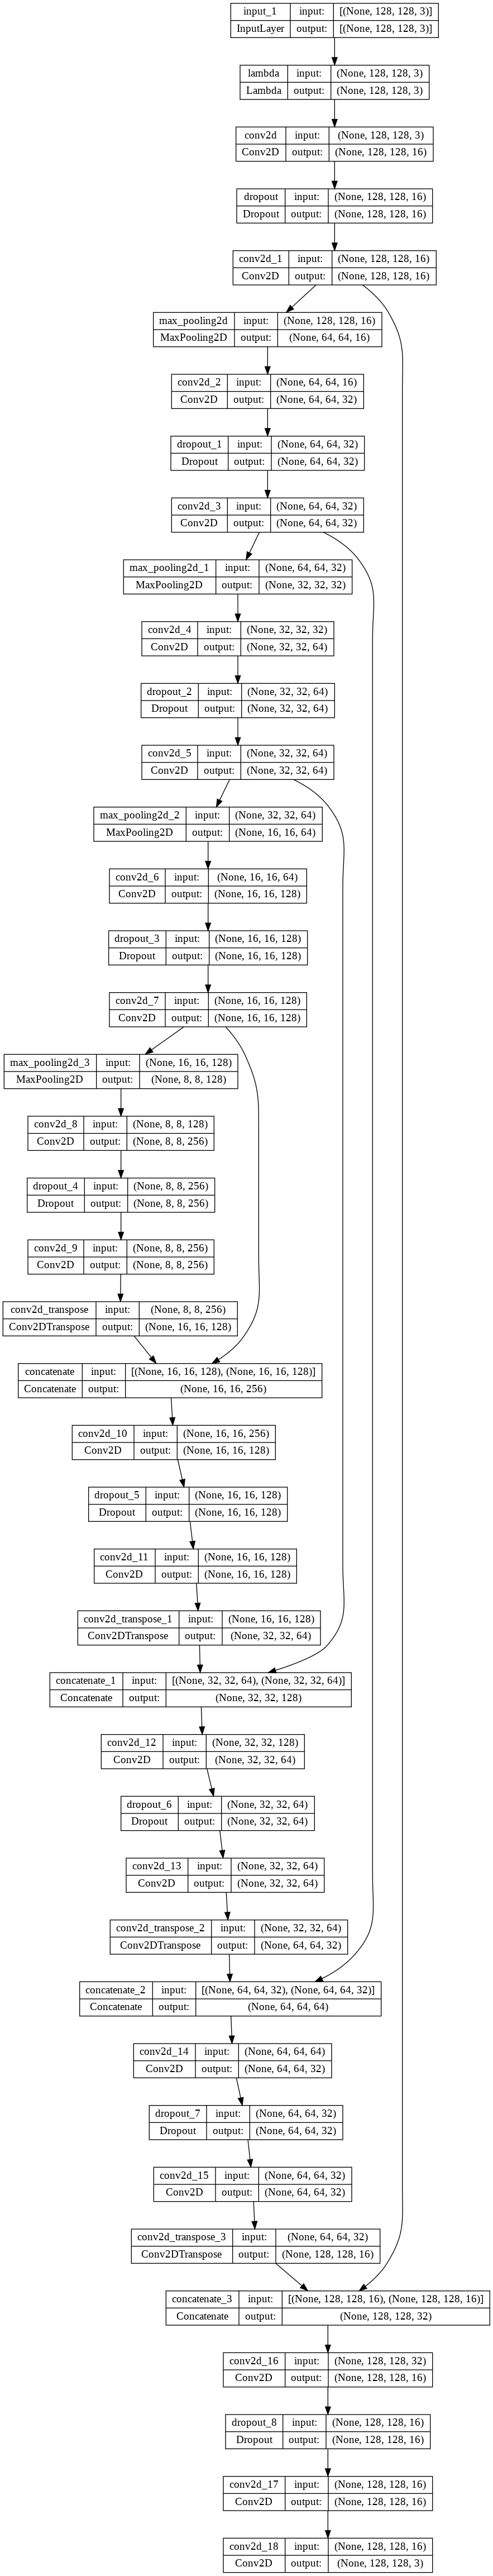

In [44]:
from keras.utils import plot_model

plot_model(unet_model, show_shapes=True)

In [45]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint(
                                                  'model_for_nuclei.h5', 
                                                  verbose=1, 
                                                  save_best_only=True
                                                  )

CALLBACKS = [
            tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
            tf.keras.callbacks.TensorBoard(log_dir='logs')
            ]

In [46]:
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 16
EPOCHS=25

unet_model_history = unet_model.fit(
                                    x=x_train, 
                                    y=y_train, 
                                    validation_split=VALIDATION_SPLIT, 
                                    batch_size=BATCH_SIZE, 
                                    epochs=EPOCHS, 
                                    callbacks=CALLBACKS
                                    )

Epoch 1/25
1/1 [==============================] - 11s 11s/step - loss: -2.9933 - accuracy: 0.0045 - val_loss: -7.2670 - val_accuracy: 0.0052
Epoch 2/25
1/1 [==============================] - 0s 73ms/step - loss: -11.9191 - accuracy: 0.0723 - val_loss: -61.2094 - val_accuracy: 0.2008
Epoch 3/25
1/1 [==============================] - 0s 57ms/step - loss: -156.9680 - accuracy: 0.2414 - val_loss: -644.3967 - val_accuracy: 0.3313
Epoch 4/25
1/1 [==============================] - 0s 72ms/step - loss: -1636.1204 - accuracy: 0.3044 - val_loss: -5523.7021 - val_accuracy: 0.3768
Epoch 5/25
1/1 [==============================] - 0s 71ms/step - loss: -13603.5449 - accuracy: 0.3324 - val_loss: -39494.6211 - val_accuracy: 0.3740
Epoch 6/25
1/1 [==============================] - 0s 70ms/step - loss: -92479.4375 - accuracy: 0.3479 - val_loss: -243065.4688 - val_accuracy: 0.3725
Epoch 7/25
1/1 [==============================] - 0s 72ms/step - loss: -548680.5000 - accuracy: 0.3567 - val_loss: -1324144.5

History info:

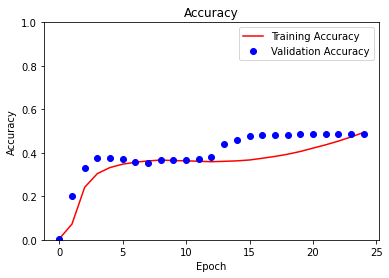

In [48]:
accry = unet_model_history.history['accuracy']
val_accry = unet_model_history.history['val_accuracy']

plt.figure()
plt.plot(unet_model_history.epoch, accry, 'r', label='Training Accuracy')
plt.plot(unet_model_history.epoch, val_accry, 'bo', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()

plt.show()


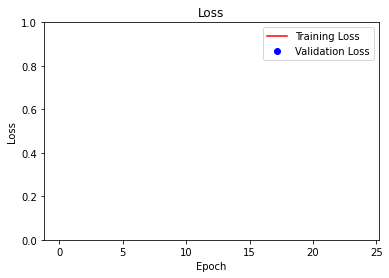

In [49]:
loss = unet_model_history.history['loss']
val_loss = unet_model_history.history['val_loss']

plt.figure()
plt.plot(unet_model_history.epoch, loss, 'r', label='Training Loss')
plt.plot(unet_model_history.epoch, val_loss, 'bo', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend()

plt.show()


In [50]:
# # predict a section of images
# preds_train = unet_model.predict(x_train[:int(x_train.shape[0]*0.9)], verbose=1)
# preds_val = unet_model.predict(x_train[int(x_train.shape[0]*0.9):], verbose=1)
# preds_test = unet_model.predict(x_valid, verbose=1)

 
# preds_train_t = (preds_train > 0.5).astype(np.uint8)
# preds_val_t = (preds_val > 0.5).astype(np.uint8)
# preds_test_t = (preds_test > 0.5).astype(np.uint8)

# # prediction = unet_model.predict( x_train[index],  verbose=1)


# # # Perform a sanity check on some random training samples
# # ix = randint(0, len(preds_train_t))
# # imshow(X_train[ix])
# # plt.show()
# # imshow(np.squeeze(Y_train[ix]))
# # plt.show()
# # imshow(np.squeeze(preds_train_t[ix]))
# # plt.show()

# # # Perform a sanity check on some random validation samples
# # ix = random.randint(0, len(preds_val_t))
# # imshow(X_train[int(X_train.shape[0]*0.9):][ix])
# # plt.show()
# # imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
# # plt.show()
# # imshow(np.squeeze(preds_val_t[ix]))
# # plt.show()

In [51]:
# try predict training images
training_predictions = unet_model.predict(x_train, verbose=1)

1/1 [==============================] - 1s 715ms/step


In [52]:
from random import randint

# index = randint(0, len(x_train)-1) # used for our plots

index = 5 # chosen randomly to repeat results

In [53]:
training_predictions[0]

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], dtype=float32)

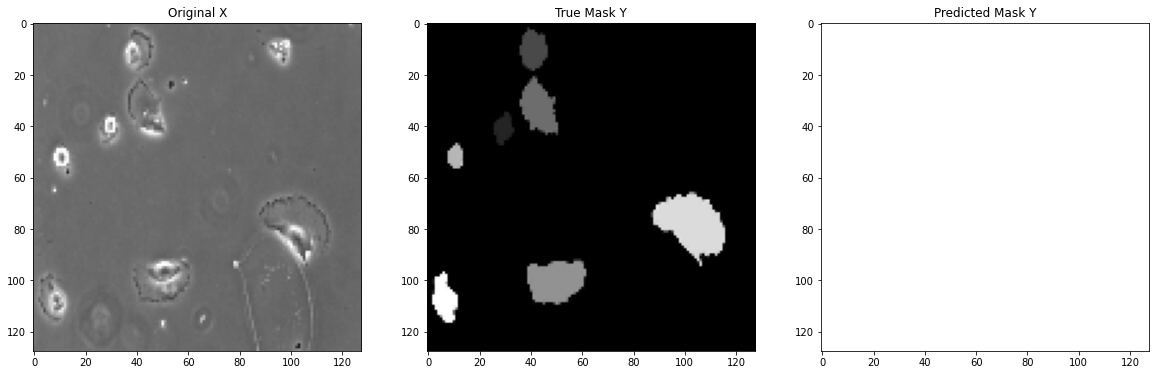

In [54]:
# Try plot

fig = plt.figure(figsize=(20,20))

plt.subplot(1, 3, 1)
plt.title("Original X")
plt.imshow( x_train[index] )

plt.subplot(1, 3, 2)
plt.title("True Mask Y")
plt.imshow( y_train[index] )

plt.subplot(1, 3, 3)
plt.title("Predicted Mask Y")
plt.imshow( training_predictions[index], cmap="gray" )

plt.show()


What does the intensity value histogram look like?:

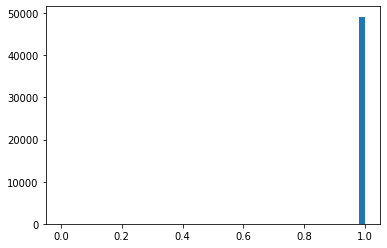

In [55]:
img = training_predictions[index]

# bins=50 and range=[0, 1] because probabilities
plt.hist(img.ravel(),bins=50,range=[0,1]); plt.show()

What about the mask?

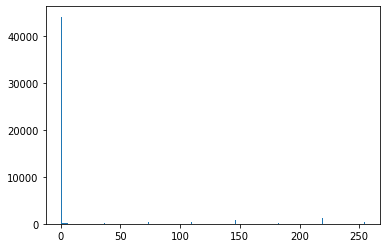

In [56]:
img = y_train[index]

plt.hist(img.ravel(),bins=255,range=[0,255]); plt.show()

Interestingly, the mask has a better spread of colours. Perhaps with later training, our predictions will contain more than just 0 and 1

Let's try update the pixel values from 0 and 1 to 0 and 255

In [57]:
preds_train_t = (training_predictions > 0.5).astype(np.uint8)

In [58]:
preds_train_t[0]

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=uint8)

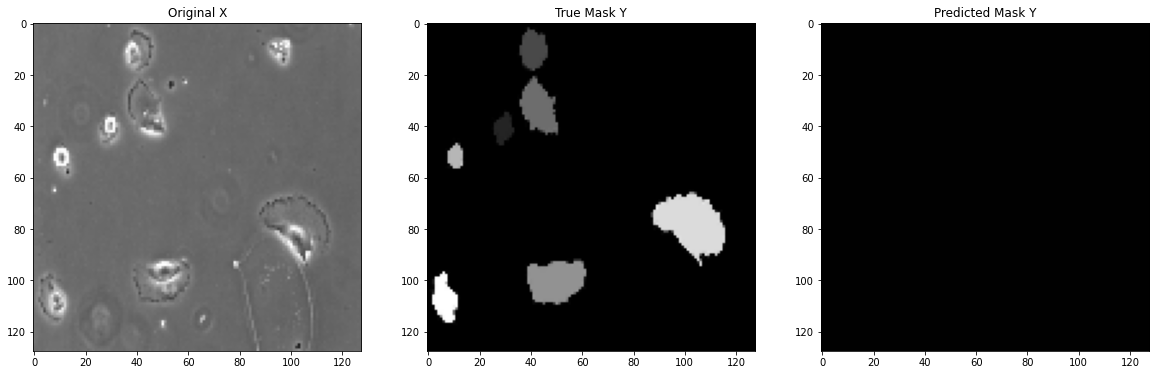

In [59]:
# Try plot

fig = plt.figure(figsize=(20,20))

plt.subplot(1, 3, 1)
plt.title("Original X")
plt.imshow( x_train[index] )

plt.subplot(1, 3, 2)
plt.title("True Mask Y")
plt.imshow( y_train[index] )

plt.subplot(1, 3, 3)
plt.title("Predicted Mask Y")
plt.imshow( preds_train_t[index], cmap="gray" )

plt.show()


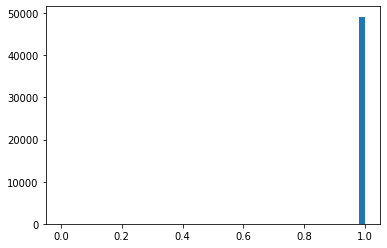

In [60]:
img = preds_train_t[index]

# bins=50 and range=[0, 1] because probabilities
plt.hist(img.ravel(),bins=50,range=[0,1]); plt.show()

In [61]:
# now, try update the values of 1 to 255:

preds_train_t_2 = (preds_train_t == 1) * 255

In [62]:
preds_train_t_2[0]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

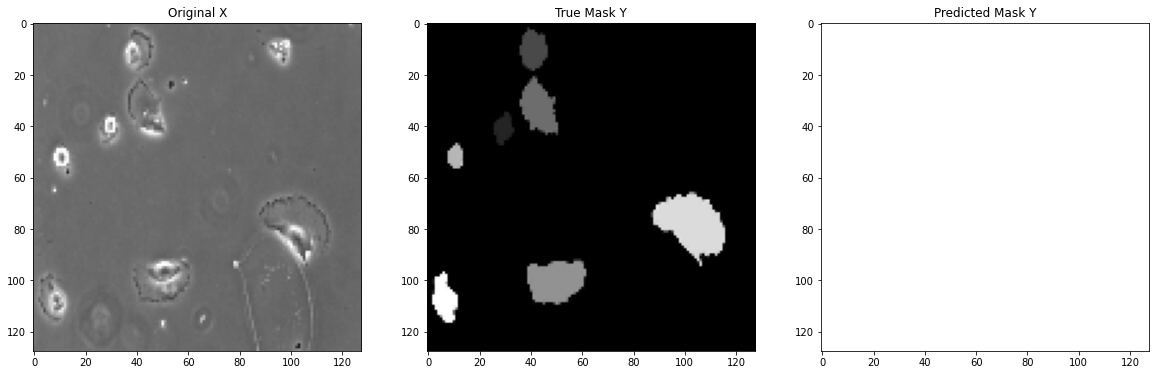

In [63]:
fig = plt.figure(figsize=(20,20))

plt.subplot(1, 3, 1)
plt.title("Original X")
plt.imshow( x_train[index] )

plt.subplot(1, 3, 2)
plt.title("True Mask Y")
plt.imshow( y_train[index] )

plt.subplot(1, 3, 3)
plt.title("Predicted Mask Y")
plt.imshow( preds_train_t_2[index], cmap="gray" )

plt.show()


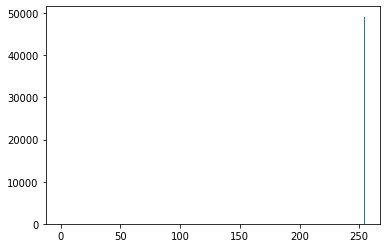

In [64]:
img = preds_train_t_2[index]

plt.hist(img.ravel(),bins=255,range=[0,255]); plt.show()

Why is that predition yellow?

In [65]:
print(x_train[index].shape)
print(y_train[index].shape)
print(preds_train_t[index].shape)
print(preds_train_t_2[index].shape)

print(type(x_train[index]))
print(type(y_train[index]))
print(type(preds_train_t[index]))
print(type(preds_train_t_2[index]))

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


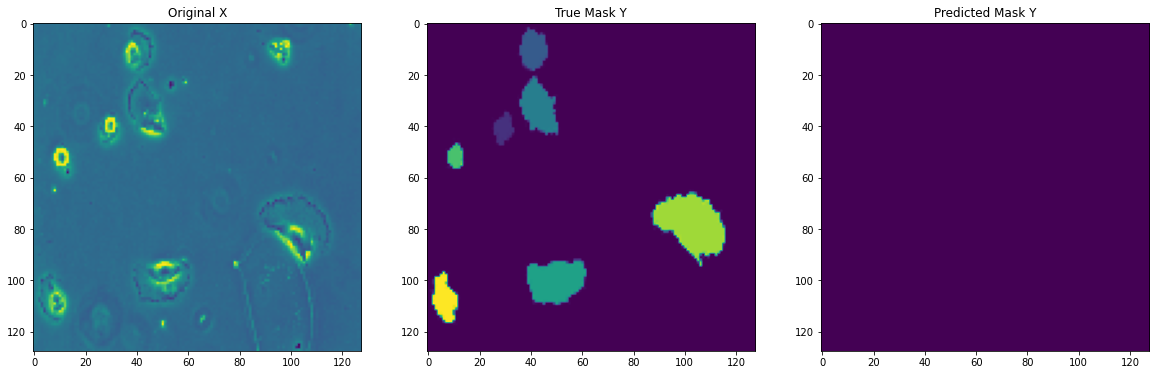

In [66]:
# try convert to grayscale:

og = cv2.cvtColor(x_train[index], cv2.COLOR_BGR2GRAY)
og_mask = cv2.cvtColor(y_train[index], cv2.COLOR_BGR2GRAY)

# try converting image type to float32
temp_prediction = preds_train_t_2[index]
img_float32 = np.float32(temp_prediction)
prediction = cv2.cvtColor(img_float32, cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize=(20,20))

plt.subplot(1, 3, 1)
plt.title("Original X")
# plt.imshow( og, cmap="gray" )
plt.imshow( og )

plt.subplot(1, 3, 2)
plt.title("True Mask Y")
# plt.imshow( og_mask, cmap="gray" )
plt.imshow( og_mask )

plt.subplot(1, 3, 3)
plt.title("Predicted Mask Y")
# plt.imshow( prediction, cmap="gray" )
plt.imshow( prediction )

plt.show()


That colour image may suggest that the predictions is a single vertical line of value 1...

After investigating different plots - we may need to train the model again with a larger dataset. Let us now try do that with a larger dataset:

# Re-training with a larger DataSet

In [67]:
google_drive_path = "/drive/MyDrive"
training_data_folder = "COMP700_Training_GT"
training_data_directory = getcwd() + google_drive_path + "/COMP700_Images/" + training_data_folder
desired_directory = ""

maxLength = -1
length = 0

# look for largest length
for root, dirs, files in walk(training_data_directory):
    if (len(files) > 0):
        length = len(files)

        if (maxLength < length):
            desired_directory = root
            maxLength = length

print(desired_directory)


/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-N2DH-SIM+/Fluo-N2DH-SIM+/02/X


Let's remove the X and prepare the data for training:

In [68]:
desired_directory = desired_directory[ : -2]

desired_directory

'/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-N2DH-SIM+/Fluo-N2DH-SIM+/02'

In [69]:
# get paths

x_training_paths = []
y_training_paths = []

for root, dirs, files in walk(desired_directory):
    if ("X" in root):
        x_training_paths = files
    else:
        y_training_paths = files

print("Length of X Training:", len(x_training_paths))
print("Length of Y Training:", len(y_training_paths))

# update the paths:

for i in range(len(x_training_paths)):
    x_training_paths[i] = desired_directory + "/X/" + x_training_paths[i]
    y_training_paths[i] = desired_directory + "/Y/" + y_training_paths[i]

Length of X Training: 150
Length of Y Training: 150


In [70]:
# We can now try to write those images into an array of images:
x_training_images = []
y_training_images = []

for i in range(len(x_training_paths)):
    x_training_images.append( cv2.imread(x_training_paths[i]) )
    y_training_images.append( cv2.imread(y_training_paths[i]) )

In [71]:
x_training_images_resized = []
y_training_images_resized = []
dim = (128, 128)

for i in range(len(y_training_images)):
    img = x_training_images[i]
    x_training_images_resized.append( cv2.resize(img, dim) ) 

    img = y_training_images[i]
    y_training_images_resized.append( cv2.resize(img, dim) ) 

Shape: (128, 128, 3)


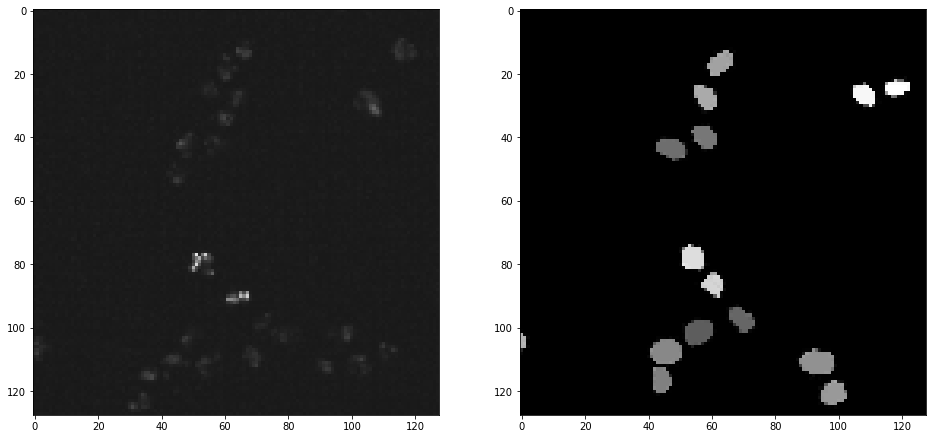

In [72]:
# Let's now try show these images side by side to verify results:

from random import randint

index = randint(0, len(x_training_images_resized) - 1)
print("Shape:", x_training_images_resized[index].shape)

fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.imshow(x_training_images_resized[index])

plt.subplot(1, 2, 2)
plt.imshow(y_training_images_resized[index])

plt.show()

In [73]:
TRAIN_LENGTH = len(x_training_images_resized)

partition_index = (int) (0.8 * TRAIN_LENGTH)

x_train = x_training_images_resized[ : partition_index ]
y_train = y_training_images_resized[ : partition_index ]

x_valid = x_training_images_resized[ : partition_index ]
y_valid = y_training_images_resized[ : partition_index ]

# convert to numpy arrays for tensorflow
x_train = np.array(x_train)
y_train = np.array(y_train)

x_valid = np.array(x_valid)
y_valid = np.array(y_valid)

data_valid = (x_valid, y_valid)

In [74]:
print(x_train.shape)

(120, 128, 128, 3)


In [75]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# rebuild
unet_model = unet_v3(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

In [76]:
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 128, 128, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  448         ['lambda_1[0][0]']               
                                )                                                                 
                                                                                            

In [77]:
# recompile
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [78]:
# retrain
unet_model_history = unet_model.fit(
                                    x=x_train, 
                                    y=y_train, 
                                    validation_split=VALIDATION_SPLIT, 
                                    batch_size=BATCH_SIZE, 
                                    epochs=EPOCHS, 
                                    callbacks=CALLBACKS
                                    )

Epoch 1/25
7/7 [==============================] - 4s 189ms/step - loss: -3.3149 - accuracy: 9.4378e-05 - val_loss: -57.7416 - val_accuracy: 0.0000e+00
Epoch 2/25
7/7 [==============================] - 0s 44ms/step - loss: -232007.8594 - accuracy: 1.0173e-05 - val_loss: -2485050.7500 - val_accuracy: 0.0000e+00
Epoch 3/25
7/7 [==============================] - 0s 44ms/step - loss: -1616762752.0000 - accuracy: 5.6514e-07 - val_loss: -14318850048.0000 - val_accuracy: 0.0000e+00
Epoch 4/25
7/7 [==============================] - 0s 45ms/step - loss: -2918925205504.0000 - accuracy: 0.0000e+00 - val_loss: -25128379351040.0000 - val_accuracy: 0.0000e+00
Epoch 5/25
7/7 [==============================] - 0s 44ms/step - loss: -2752644540006400.0000 - accuracy: 0.0000e+00 - val_loss: -16368864468140032.0000 - val_accuracy: 0.0000e+00
Epoch 6/25
7/7 [==============================] - 0s 44ms/step - loss: -879370158441758720.0000 - accuracy: 0.0000e+00 - val_loss: -5779539440695246848.0000 - val_accu

Try predict now:

In [79]:
# try predict training images
training_predictions = unet_model.predict(x_train, verbose=1)

4/4 [==============================] - 1s 166ms/step


In [80]:
training_predictions[0]

array([[[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       ...,

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]

For some reason, the image is being predicted as NaN - And some results on Stack Overflow suggest it is because some of my images contain that in the image. Let us investigate:

In [81]:
#test x_train

count = 0; min = 0

for picture in x_train:
    min = np.min(picture)

    if (np.isnan(min)):
        count += 1

print("There are", count, "picture(s) with NaN inside")


There are 0 picture(s) with NaN inside


In [82]:
#test y_train

count = 0; min = 0

for picture in y_train:
    min = np.min(picture)

    if (np.isnan(min)):
        count += 1

print("There are", count, "picture(s) with NaN inside")


There are 0 picture(s) with NaN inside


That is weird, does the code work for predicted image?

In [83]:
picture = training_predictions[0]

min = np.min(picture)

if (np.isnan(min)):
    print("Yes, NaN found")

Yes, NaN found


SO! We have a model that is producing NaN, and the input images are all stable... What else could be the problem?

There is a 'cheat sheet' available on Stack Overflow here:

One of the things I can try next is to try a different compiler:

In [84]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# rebuild
unet_model = unet_v3(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

In [85]:
'''
# This is the default optimizer from tensorflow
tf.keras.optimizers.Adam(
                        learning_rate=0.001,
                        beta_1=0.9,
                        beta_2=0.999,
                        epsilon=1e-07,
                        amsgrad=False,
                        name='Adam',
                        **kwargs
                        ) 
'''

# try again with this optimizer (shouild be default)

optimizer  = tf.keras.optimizers.Adam(
                                      learning_rate=0.001,
                                      beta_1=0.9,
                                      beta_2=0.999,
                                      epsilon=1e-07,
                                      amsgrad=False,
                                      name='Adam'
                                      ) 

unet_model.compile(optimizer=optimizer,
                    loss='binary_crossentropy',
                    metrics=['accuracy', 'mse']
                  )

In [86]:
# Recall that this is our callbacks:

# CALLBACKS = [
#             tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
#             tf.keras.callbacks.TensorBoard(log_dir='logs')
#             ]

In [87]:
# retrain
unet_model_history = unet_model.fit(
                                    x=x_train, 
                                    y=y_train, 
                                    validation_split=VALIDATION_SPLIT, 
                                    batch_size=BATCH_SIZE, 
                                    epochs=EPOCHS, 
                                    callbacks=CALLBACKS
                                    )

Epoch 1/25
7/7 [==============================] - 2s 149ms/step - loss: -62.6460 - accuracy: 0.4227 - mse: 1615.0143 - val_loss: -1470.1611 - val_accuracy: 0.9440 - val_mse: 1652.1942
Epoch 2/25
7/7 [==============================] - 0s 46ms/step - loss: -4423370.5000 - accuracy: 0.9780 - mse: 1609.9983 - val_loss: -43045340.0000 - val_accuracy: 0.9980 - val_mse: 1651.0844
Epoch 3/25
7/7 [==============================] - 0s 45ms/step - loss: -21638811648.0000 - accuracy: 0.9966 - mse: 1608.6368 - val_loss: -167288848384.0000 - val_accuracy: 0.9981 - val_mse: 1649.6517
Epoch 4/25
7/7 [==============================] - 0s 45ms/step - loss: -24879636152320.0000 - accuracy: 0.9991 - mse: 1607.9515 - val_loss: -201182643486720.0000 - val_accuracy: 1.0000 - val_mse: 1649.6310
Epoch 5/25
7/7 [==============================] - 0s 47ms/step - loss: -13336276107264000.0000 - accuracy: 0.9999 - mse: 1607.8950 - val_loss: -98942328374296576.0000 - val_accuracy: 1.0000 - val_mse: 1649.6317
Epoch 6

In [88]:
# try predict training images
training_predictions = unet_model.predict(x_train, verbose=1)

training_predictions[0]

4/4 [==============================] - 0s 31ms/step


array([[[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       ...,

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]

Still nothing... What about adding some BatchNormalizations?

In [89]:
'''
img = keras.Input(shape=[height, width, 2])
cnn = keras.layers.BatchNormalization()(img)
for layer in range(nlayers):
  nfilters = nfil * (layer + 1)
  cnn = keras.layers.Conv2D(nfilters, (ksize, ksize), padding='same')(cnn)
  cnn = keras.layers.Activation('elu')(cnn)
  cnn = keras.layers.BatchNormalization()(cnn)
  cnn = keras.layers.MaxPooling2D(pool_size=(2, 2))(cnn)
  cnn = keras.layers.Dropout(dprob)(cnn)
cnn = keras.layers.Flatten()(cnn)
ltgprob = keras.layers.Dense(10, activation='sigmoid')(cnn)
'''

# original author: "Sreenivas Bhattiprolu"
# Github directory: "Python for Microscopists"
# URL: https://github.com/bnsreenu/python_for_microscopists
def unet_v4(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS):
    #Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)
    n = keras.layers.BatchNormalization()(s) # alex added

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(n)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    n1 = keras.layers.BatchNormalization()(c1) # alex added
    p1 = MaxPooling2D((2, 2))(n1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    n2 = keras.layers.BatchNormalization()(c2) # alex added
    p2 = MaxPooling2D((2, 2))(n2)
    
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    n3 = keras.layers.BatchNormalization()(c3) # alex added
    p3 = MaxPooling2D((2, 2))(n3)
    
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    n4 = keras.layers.BatchNormalization()(c4) # alex added
    p4 = MaxPooling2D(pool_size=(2, 2))(n4)
    
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9) # modified initial parameter to 3
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model
###

In [90]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# rebuild
unet_model_2 = unet_v4(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

unet_model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

unet_model_2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_3 (Lambda)              (None, 128, 128, 3)  0           ['input_4[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 3)  12         ['lambda_3[0][0]']               
 alization)                                                                                       
                                                                                            

In [91]:
# retrain
unet_model_history_2 = unet_model_2.fit(
                                        x=x_train, 
                                        y=y_train, 
                                        validation_split=VALIDATION_SPLIT, 
                                        batch_size=BATCH_SIZE, 
                                        epochs=EPOCHS, 
                                        callbacks=CALLBACKS
                                        )

Epoch 1/25
7/7 [==============================] - 3s 165ms/step - loss: -8151.0068 - accuracy: 0.0859 - val_loss: -29095.7168 - val_accuracy: 7.4259e-04
Epoch 2/25
7/7 [==============================] - 0s 47ms/step - loss: -11935834.0000 - accuracy: 0.0067 - val_loss: -485480.8438 - val_accuracy: 0.0000e+00
Epoch 3/25
7/7 [==============================] - 0s 49ms/step - loss: -2686297856.0000 - accuracy: 4.5381e-04 - val_loss: -93876680.0000 - val_accuracy: 0.0000e+00
Epoch 4/25
7/7 [==============================] - 0s 47ms/step - loss: -271297921024.0000 - accuracy: 4.6342e-05 - val_loss: -8094820864.0000 - val_accuracy: 0.0000e+00
Epoch 5/25
7/7 [==============================] - 0s 48ms/step - loss: -17433413812224.0000 - accuracy: 1.5824e-05 - val_loss: -396965707776.0000 - val_accuracy: 0.0000e+00
Epoch 6/25
7/7 [==============================] - 0s 48ms/step - loss: -716579792748544.0000 - accuracy: 2.2606e-06 - val_loss: -12249377800192.0000 - val_accuracy: 0.0000e+00
Epoch 7

In [93]:
# try predict training images
training_predictions = unet_model_2.predict(x_train, verbose=1)

training_predictions[0]

4/4 [==============================] - 1s 104ms/step


array([[[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       ...,

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]

That didnt appear to help!

Does it improve if we add validation data?

In [94]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# rebuild
unet_model_3 = unet_v3(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

unet_model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

unet_model_3.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_4 (Lambda)              (None, 128, 128, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 128, 128, 16  448         ['lambda_4[0][0]']               
                                )                                                                 
                                                                                            

In [95]:
# retrain
unet_model_history_3 = unet_model_3.fit(
                                        x=x_train, 
                                        y=y_train, 
                                        validation_split=VALIDATION_SPLIT, 
                                        validation_data=data_valid,
                                        batch_size=BATCH_SIZE, 
                                        epochs=EPOCHS, 
                                        callbacks=CALLBACKS
                                        )

Epoch 1/25
8/8 [==============================] - 3s 230ms/step - loss: -126.6103 - accuracy: 0.0112 - val_loss: -2377.8599 - val_accuracy: 6.1035e-05
Epoch 2/25
8/8 [==============================] - 0s 54ms/step - loss: -17916582.0000 - accuracy: 0.0013 - val_loss: -246219008.0000 - val_accuracy: 0.0000e+00
Epoch 3/25
8/8 [==============================] - 0s 54ms/step - loss: -191864389632.0000 - accuracy: 1.8717e-04 - val_loss: -2164650278912.0000 - val_accuracy: 0.0000e+00
Epoch 4/25
8/8 [==============================] - 0s 54ms/step - loss: -414787842342912.0000 - accuracy: 6.6121e-06 - val_loss: -4483621050122240.0000 - val_accuracy: 0.0000e+00
Epoch 5/25
8/8 [==============================] - 0s 54ms/step - loss: -366949876782596096.0000 - accuracy: 0.0000e+00 - val_loss: -3265870866767937536.0000 - val_accuracy: 0.0000e+00
Epoch 6/25
8/8 [==============================] - 0s 53ms/step - loss: nan - accuracy: 0.3333 - val_loss: nan - val_accuracy: 1.0000
Epoch 7/25
8/8 [======

In [96]:
# try predict training images
training_predictions = unet_model_3.predict(x_train, verbose=1)

training_predictions[0]

4/4 [==============================] - 0s 18ms/step


array([[[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       ...,

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]

This is starting to deflate me... Perhaps the mask images need to be modified:

In [97]:
y_train[y_train > 0] = 255



In [98]:
np.max(y_train[0])

255

Let's try train now:

In [99]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# rebuild
unet_model_4 = unet_v3(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

unet_model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

unet_model_4.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_5 (Lambda)              (None, 128, 128, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv2d_95 (Conv2D)             (None, 128, 128, 16  448         ['lambda_5[0][0]']               
                                )                                                                 
                                                                                            

In [100]:
# retrain
unet_model_history_4 = unet_model_4.fit(
                                        x=x_train, 
                                        y=y_train, 
                                        validation_split=VALIDATION_SPLIT, 
                                        # validation_data=data_valid,
                                        batch_size=BATCH_SIZE, 
                                        epochs=EPOCHS, 
                                        callbacks=CALLBACKS
                                        )

Epoch 1/25
7/7 [==============================] - 2s 103ms/step - loss: -94.8745 - accuracy: 0.2701 - val_loss: -2015.8340 - val_accuracy: 0.5186
Epoch 2/25
7/7 [==============================] - 0s 45ms/step - loss: -6578949.5000 - accuracy: 0.4723 - val_loss: -77518176.0000 - val_accuracy: 0.4267
Epoch 3/25
7/7 [==============================] - 0s 46ms/step - loss: -37690601472.0000 - accuracy: 0.3783 - val_loss: -336958160896.0000 - val_accuracy: 0.2059
Epoch 4/25
7/7 [==============================] - 0s 45ms/step - loss: -43299113009152.0000 - accuracy: 0.2681 - val_loss: -476792238374912.0000 - val_accuracy: 0.1337
Epoch 5/25
7/7 [==============================] - 0s 44ms/step - loss: -38306731708645376.0000 - accuracy: 0.2012 - val_loss: -223848112010035200.0000 - val_accuracy: 0.0939
Epoch 6/25
7/7 [==============================] - 0s 46ms/step - loss: -10084561220775444480.0000 - accuracy: 0.2403 - val_loss: -62301930829880754176.0000 - val_accuracy: 0.2247
Epoch 7/25
7/7 [=

In [101]:
# try predict training images
training_predictions = unet_model_4.predict(x_train, verbose=1)

training_predictions[0]

4/4 [==============================] - 0s 30ms/step


array([[[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       ...,

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]

I think at this point I need to stop, and investigate other model implementations. I cannot get this to stop - and fiddling may just be making it worse.